In [1]:
%matplotlib inline
import tensorflow as tf
from os import getcwd
print(tf.__version__)

2.0.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
path_daily_min_temperatures = f"{getcwd()}/../tmp2/daily-min-temperatures.csv"

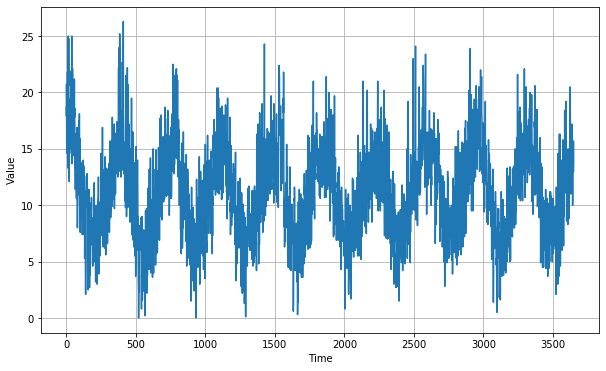

In [4]:
import csv

time_step = []
temps = []

with open(path_daily_min_temperatures) as csvfile:    
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    steps=0
    for row in reader:
        temps.append(float(row[1]))
        time_step.append(steps)
        steps = steps + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [5]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)
    # YOUR CODE HERE

In [7]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [8]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding="causal", 
                           activation="relu", input_shape=[None, 1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 10s 967ms/step - loss: 31.1549 - mae: 31.6551
Epoch 2/100
10/10 [==============================] - 1s 131ms/step - loss: 30.5753 - mae: 31.0783
Epoch 3/100
10/10 [==============================] - 1s 138ms/step - loss: 29.7469 - mae: 30.1792
Epoch 4/100
10/10 [==============================] - 1s 141ms/step - loss: 28.5816 - mae: 29.0582
Epoch 5/100
10/10 [==============================] - 1s 139ms/step - loss: 27.1349 - mae: 27.6970
Epoch 6/100
10/10 [==============================] - 1s 121ms/step - loss: 25.5287 - mae: 25.9975
Epoch 7/100
10/10 [==============================] - 1s 149ms/step - loss: 23.3412 - mae: 23.8407
Epoch 8/100
10/10 [==============================] - 1s 140ms/step - loss: 20.6980 - mae: 21.1120
Epoch 9/100
10/10 [==============================] - 1s 139ms/step - loss: 17.4437 - mae: 17.8083
Epoch 10/100
10

[1e-08, 0.0001, 0, 60]

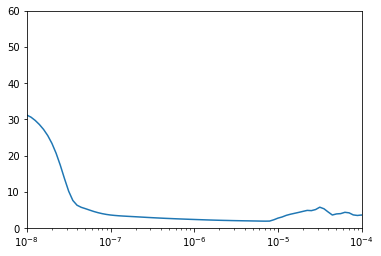

In [9]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [10]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=60, kernel_size=5, strides=1, padding="causal",
                           activation="relu", input_shape=[None, 1]),
    tf.keras.layers.LSTM(60, return_sequences=True),
    tf.keras.layers.LSTM(60, return_sequences=True),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])
optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set,epochs=150, verbose=2)

Epoch 1/150
25/25 - 7s - loss: 9.9623 - mae: 10.5788
Epoch 2/150
25/25 - 2s - loss: 2.5936 - mae: 3.0496
Epoch 3/150
25/25 - 2s - loss: 1.9328 - mae: 2.3879
Epoch 4/150
25/25 - 2s - loss: 1.8620 - mae: 2.3160
Epoch 5/150
25/25 - 2s - loss: 1.8200 - mae: 2.2715
Epoch 6/150
25/25 - 2s - loss: 1.7917 - mae: 2.2419
Epoch 7/150
25/25 - 2s - loss: 1.7631 - mae: 2.2129
Epoch 8/150
25/25 - 2s - loss: 1.7459 - mae: 2.1938
Epoch 9/150
25/25 - 2s - loss: 1.7219 - mae: 2.1687
Epoch 10/150
25/25 - 2s - loss: 1.7014 - mae: 2.1483
Epoch 11/150
25/25 - 2s - loss: 1.6838 - mae: 2.1305
Epoch 12/150
25/25 - 2s - loss: 1.6661 - mae: 2.1134
Epoch 13/150
25/25 - 2s - loss: 1.6559 - mae: 2.1020
Epoch 14/150
25/25 - 2s - loss: 1.6440 - mae: 2.0905
Epoch 15/150
25/25 - 2s - loss: 1.6326 - mae: 2.0777
Epoch 16/150
25/25 - 2s - loss: 1.6254 - mae: 2.0699
Epoch 17/150
25/25 - 2s - loss: 1.6170 - mae: 2.0609
Epoch 18/150
25/25 - 2s - loss: 1.6078 - mae: 2.0499
Epoch 19/150
25/25 - 2s - loss: 1.6057 - mae: 2.0479
E

In [11]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

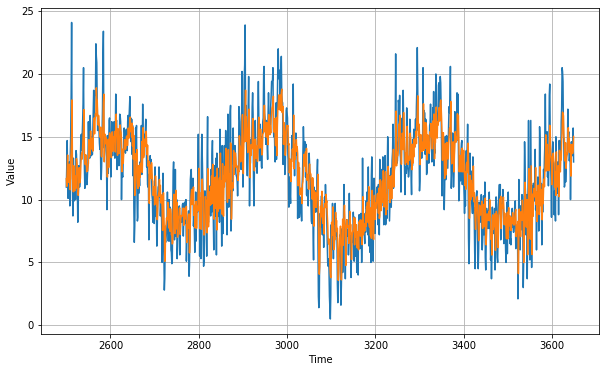

In [12]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [13]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

1.7814313

In [14]:
print(rnn_forecast)

[11.666199 11.050341 12.272292 ... 13.673089 13.805953 15.023554]
